<a href="https://colab.research.google.com/github/noahcorona/ucsb-ece-160/blob/main/Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Noah Corona**

---

# **Mini-Project 2: Tempo Estimation for Musical Audio Signals**

# **Setup: Google Drive**

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setup: Imports**

In [ ]:
!pip install essentia
import os
import IPython
import matplotlib.pyplot as plt
from matplotlib import cycler
import math
import numpy as np
from essentia.standard import MonoLoader
from scipy.signal import scipy_stft, find_peaks
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Global constants**

**Audio sample rate and frequency**

In [ ]:
# sample rate = 44.1kHz
sample_rate, sample_freq = 44100, 1/44100

**Graph configuration**

In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.prop_cycle'] = cycler(color=['mediumpurple', "0.7"])
axis_title_size = 20

**Audio data source**

In [ ]:
# look in 'media dir' folder, return the name (omitting extension) of
# all files in the directory that have extension 'wav'
media_dir = "/content/drive/Shared drives/ECE160-Visell-2022/Media Files/tempo_dataFolder/"
file_list = [file[:-4] for file in os.listdir(media_dir) if file.endswith('.wav')]

# **Setup**


 **Data extraction**
 
        1.   Create dictionary for audio data
        2.   Extract file list from Google Drive tempo data folder
        3.   For each audio file
            - Extract mono sample with essentia MonoLoader
            - Extract 'true' BPM data from bpm file
            - Append data to *audio_data* dictionary



In [ ]:
# dictionary storing all data for the program
audio_data = dict()

# loop through all files from data source
for filename in file_list:
    # initialize dict
    audio_data[filename] = dict()

    beat_file_filepath = media_dir + filename + ' beat.bpm'
    audio_file_filepath = media_dir + '/' + filename + '.wav'

    # load bpm from file data
    f = open(beat_file_filepath)
    audio_data[filename]['real_bpm'] = f.read()
    f.close()

    # load audio from file data
    loader = MonoLoader(filename=audio_file_filepath)
    audio = loader()
    audio_data[filename]['audio'] = np.array(audio, dtype=float)

**Plot samples**

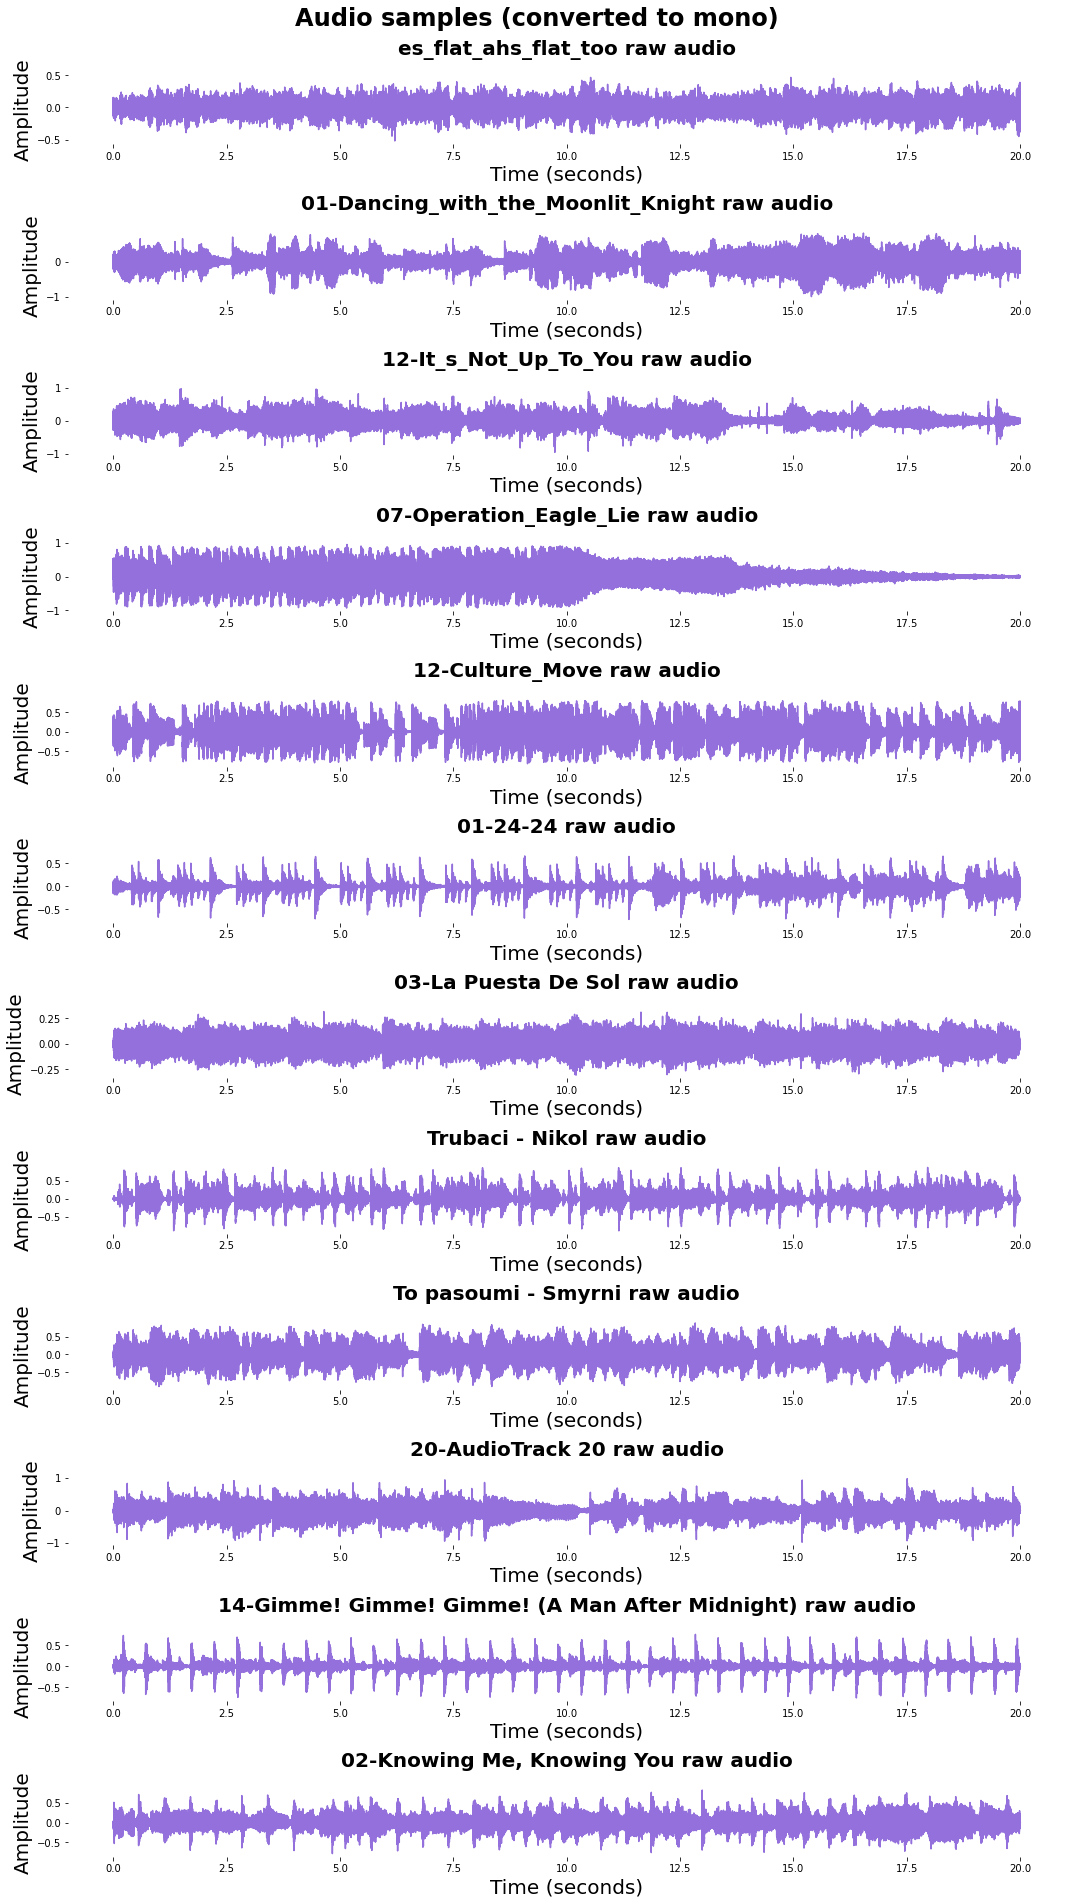

In [ ]:
audio_samples = audio_data.items()
num_samples = len(audio_data.items())
num_cols = 1
num_rows = int(num_samples)

fig = plt.figure(figsize=(15, 30), frameon=False)
plt.suptitle('Audio samples (converted to mono)', fontsize=24, fontweight='bold')
plt.axis('off')
for idx, (name, audio_sample) in enumerate(audio_data.items()):
    current_plot = idx * num_cols
    audio = audio_sample['audio']
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' raw audio')
    ax.set_xlabel('Time (seconds)', fontsize=axis_title_size)
    ax.set_ylabel('Amplitude', fontsize=axis_title_size)
    time_steps = np.linspace(0, audio.size/sample_rate, audio.size)
    ax.plot(time_steps, audio)
    ax.axis('auto')

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()
print('\n\n\n')

# **Step 1: STFT**



**Helper function:**


         1. Calculates number of segments based on window size
         2. Pads the audio with with length of our FFT (for the last hop)
         3. Calculate FFT of window, add to STFT result array

         STFT result array stores the FFT results (along each row)
            - it has as many columns as there are segments
    
        segment_times stores the index of each segment

In [ ]:
def stft(audio, fft_size, segment_size, hop_size):
    window = np.hanning(segment_size)
    padded_audio = np.concatenate((audio, np.zeros(fft_size)))
    num_segments = 1 + int(math.ceil(audio.size / float(hop_size)))
    STFT = np.empty(shape=(fft_size, num_segments), dtype=float)
    for segment_index in range(num_segments):
        segment_start = segment_index * hop_size
        segment = window * padded_audio[segment_start:segment_start + segment_size]
        segment_padded = np.append(segment, np.zeros((fft_size * 2) - segment_size))
        segment_fft = np.fft.fft(segment_padded)
        segment_fft = segment_fft
        STFT[:, segment_index] = segment_fft[:fft_size]
    STFT = 20 * np.log10(np.abs(STFT))
    STFT = np.clip(STFT, -40, 200)
    return STFT

**Main function**

        1.   Compute STFT using my function, then using SciPy (SciPy for comparison only)
        3.   Update audio data dict with both STFT arrays
        4.   Graph the results
                Row represents 1 audio sample
                Column 1: Raw audio data
                Column 2: My STFT
                Column 3: Result of scipy.signal.stft with identical algorithm parameters



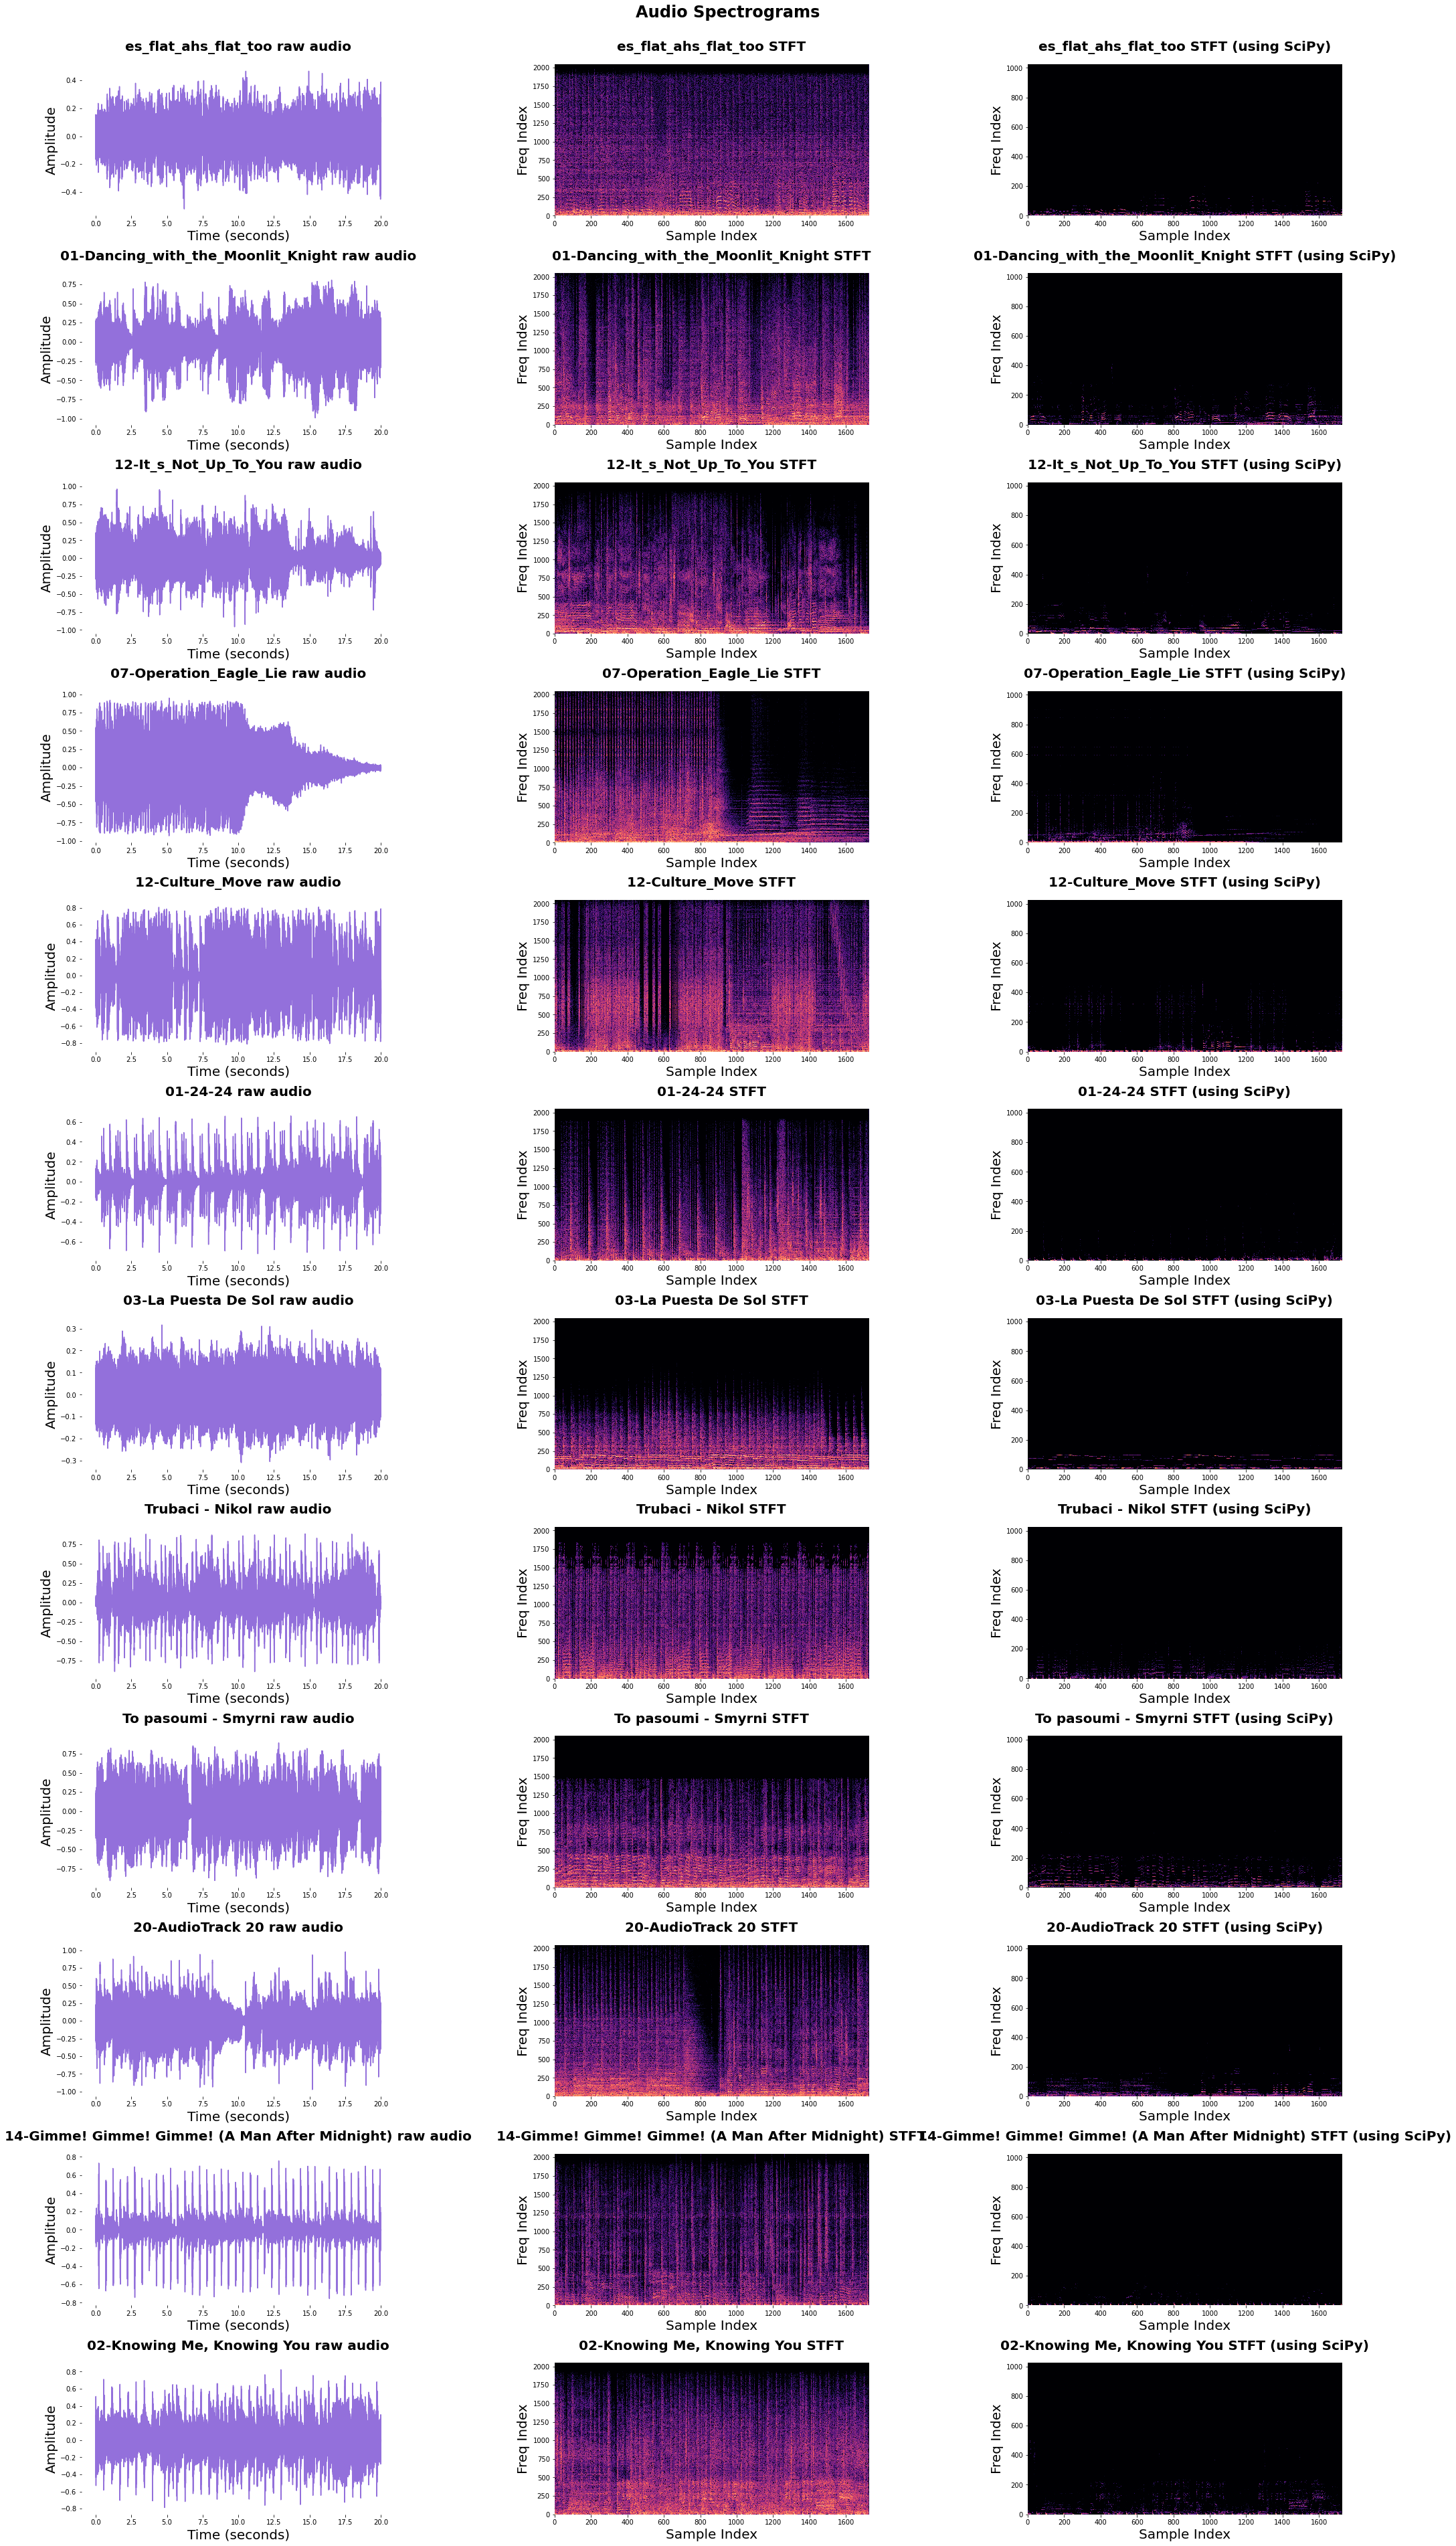

In [ ]:
# Steps 1-3
for name, audio_sample in audio_data.items():
    fft_size = 2048
    segment_size = 1024
    hop_size = 512

    audio_data[name]['stft'] = stft(audio_sample['audio'],
                                    fft_size,
                                    segment_size,
                                    hop_size)



    _, _, scipy_STFT = scipy_stft(audio_sample['audio'], 
                                    fs=sample_freq,
                                    nfft=fft_size,
                                    noverlap=int(segment_size*0.5),
                                    nperseg=segment_size)
    scipy_STFT = 20 * np.log10(np.abs(scipy_STFT))
    scipy_STFT = np.clip(scipy_STFT, -40, 200)
    audio_data[name]['scipy_stft'] = scipy_STFT

# Step 4
audio_samples = audio_data.items()
num_samples = len(audio_data.items())
num_cols = 3
num_rows = int(num_samples)

fig = plt.figure(figsize=(30, 60), frameon=False)
plt.suptitle('Audio Spectrograms', fontsize=24, fontweight='bold')
plt.axis('off')

for idx, (name, audio_sample) in enumerate(audio_data.items()):
    current_plot = idx * num_cols
    # Plot raw audio
    audio = audio_sample['audio']
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' raw audio')
    ax.set_xlabel('Time (seconds)', fontsize=axis_title_size)
    ax.set_ylabel('Amplitude', fontsize=axis_title_size)
    time_steps = np.linspace(0, audio.size/sample_rate, audio.size)
    ax.plot(time_steps, audio)
    ax.axis('auto')

    # Plot output of my STFT
    STFT = stft(audio_sample['audio'])
    audio_data[name]['stft'] = STFT
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 2)
    ax.set_title(name + ' STFT')
    ax.set_xlabel('Sample Index', fontsize=axis_title_size)
    ax.set_ylabel('Freq Index', fontsize=axis_title_size)
    ax.imshow(STFT, origin='lower', cmap='magma', interpolation='nearest', aspect='auto')
    ax.axis('auto')

    # Plot output of SciPy STFT
    scipy_STFT = audio['sample']['scipy_stft']
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 3)
    ax.set_title(name + ' STFT (using SciPy)')
    ax.set_xlabel('Sample Index', fontsize=axis_title_size)
    ax.set_ylabel('Freq Index', fontsize=axis_title_size)
    ax.imshow(scipy_STFT, origin='lower', cmap='magma', interpolation='nearest', aspect='auto')
    ax.axis('auto')

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()
print('\n\n\n')

# **Step 2: Novelty Function Computation and Visualization**

**Helper function**

    1.   Take the difference of each sample in the STFT and the last
    2.   Set negative results to zero
    3.   Sum the differences

In [ ]:
def novelty(x):
    novelty = np.diff(x, n=1)
    novelty[novelty < 0] = 0
    novelty = np.sum(novelty, axis=0)
    novelty /= np.max(novelty,axis=0)
    return novelty

**Main function**

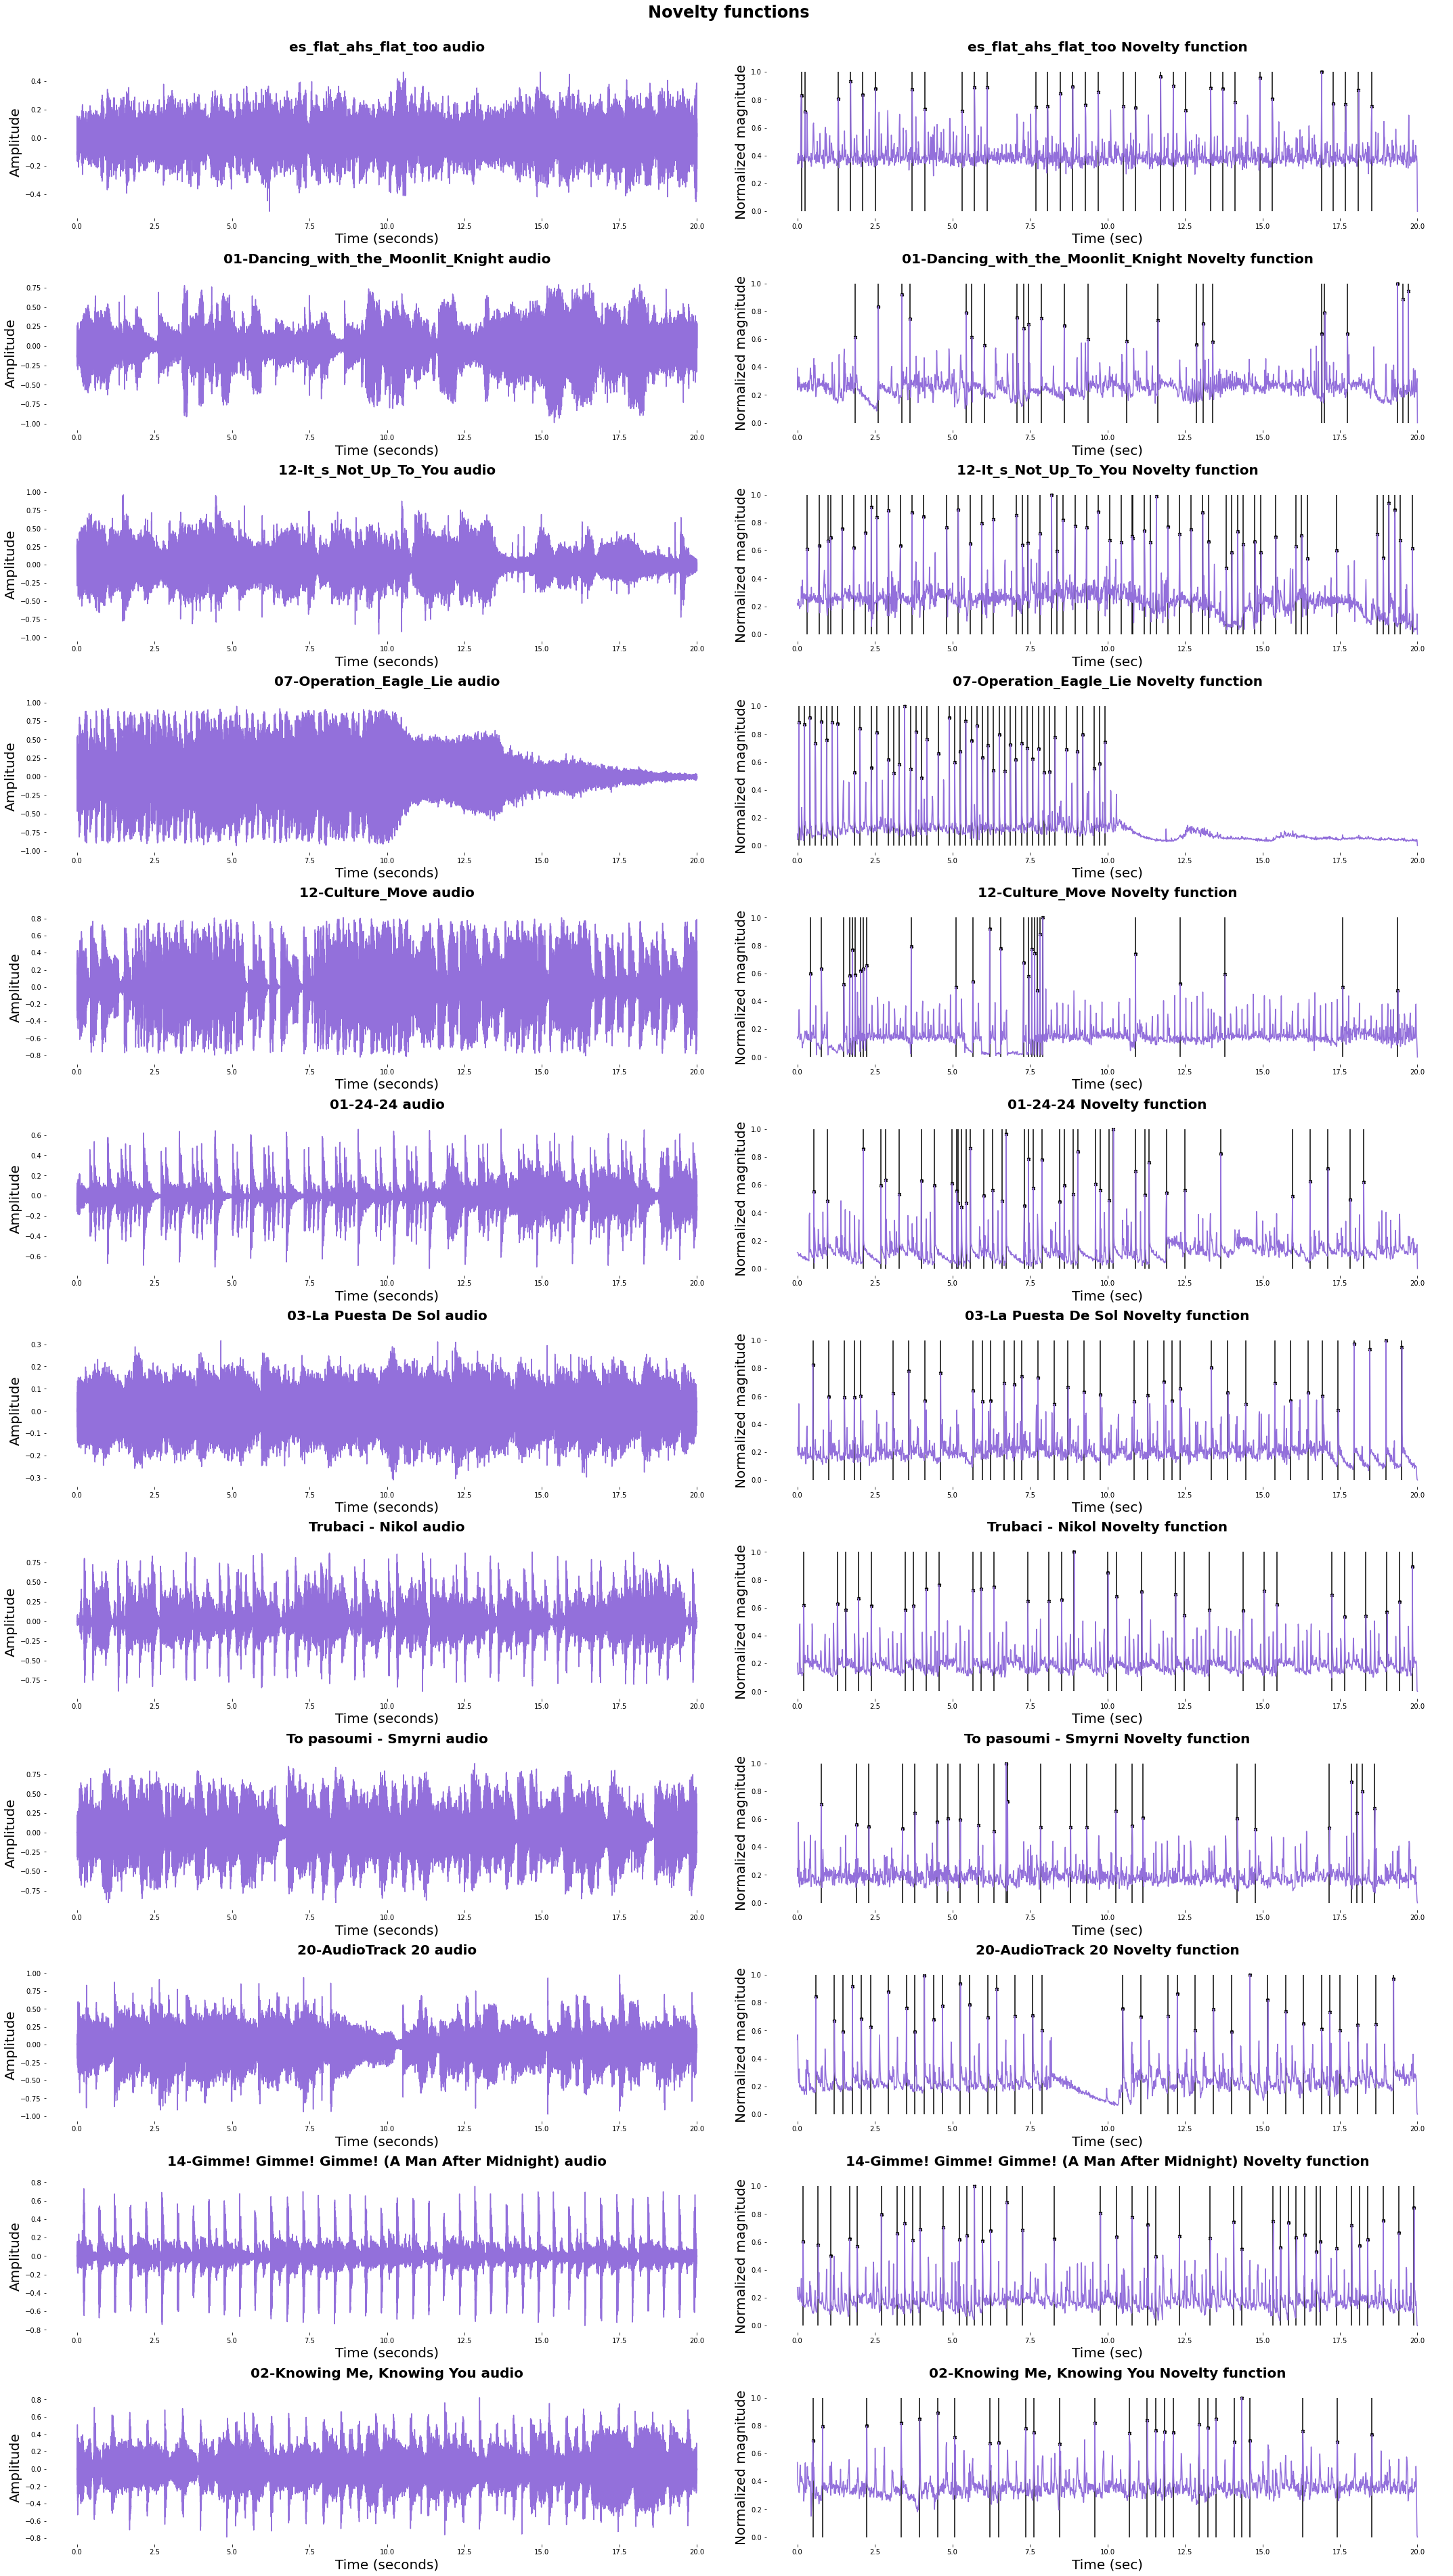

In [ ]:
num_samples = len(audio_data.items())
num_cols = 2
num_rows = int(num_samples)

fig = plt.figure(figsize=(30, 60), frameon=False)
plt.suptitle('Novelty functions', fontsize=24, fontweight='bold')
plt.axis('off')

current_plot = 1
for name, audio_sample in audio_data.items():
    # 1. Plot raw audio
    audio = audio_sample['audio']
    ax = fig.add_subplot(num_rows, num_cols, current_plot)
    ax.set_title(name + ' audio')
    ax.set_xlabel('Time (seconds)', fontsize=axis_title_size)
    ax.set_ylabel('Amplitude', fontsize=axis_title_size)
    time_steps = np.linspace(0, audio.size/sample_rate, audio.size)
    ax.plot(time_steps, audio)
    ax.axis('auto')

    # 2. Use STFT to get novelty function
    STFT = audio_data[name]['stft']
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' Novelty function')
    ax.set_xlabel('Time (sec)', fontsize=axis_title_size)
    ax.set_ylabel('Normalized magnitude', fontsize=axis_title_size)
    time_steps = np.linspace(0, audio.size/sample_rate, int(math.ceil(audio.size / float(hop_size))))
    f = novelty(STFT)
    ax.plot(time_steps, f)

    # 3. Get peaks of novelty function
    peaks, _ = find_peaks(f, prominence=0.4)
    time_steps = np.linspace(0, float(audio.size/sample_rate), len(peaks))
    peak_times = (peaks * hop_size)/sample_rate
    audio_data[name]['onset_times'] = peak_times
    plt.scatter(peak_times, f[peaks], marker='X', c='black', s=20)
    plt.vlines(peak_times, 0, 1, linestyles='solid', colors='black')
    ax.axis('auto')

    current_plot += 2

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()
print('\n\n\n')

# **Tempo Estimation**



In [ ]:

for name, audio_sample in audio_data.items():
    number_onsets = len(audio_sample['onset_times'])
    length_seconds = audio_sample['audio'].size / sample_rate

    est_bpm = number_onsets / length_seconds * 60
    real_bpm = float(audio_sample['real_bpm'])


    print()
    print(name.upper())
    print('     Estimated BPM: ' + "{:05.1f}".format(est_bpm))
    print('     Actual BPM:    ' + "{:05.1f}".format(real_bpm))
    print()


ES_FLAT_AHS_FLAT_TOO
     Estimated BPM: 096.0
     Actual BPM:    151.4


01-DANCING_WITH_THE_MOONLIT_KNIGHT
     Estimated BPM: 072.0
     Actual BPM:    080.1


12-IT_S_NOT_UP_TO_YOU
     Estimated BPM: 171.0
     Actual BPM:    080.3


07-OPERATION_EAGLE_LIE
     Estimated BPM: 141.0
     Actual BPM:    082.0


12-CULTURE_MOVE
     Estimated BPM: 078.0
     Actual BPM:    083.0


01-24-24
     Estimated BPM: 123.0
     Actual BPM:    104.2


03-LA PUESTA DE SOL
     Estimated BPM: 111.0
     Actual BPM:    116.9


TRUBACI - NIKOL
     Estimated BPM: 093.0
     Actual BPM:    110.3


TO PASOUMI - SMYRNI
     Estimated BPM: 075.0
     Actual BPM:    080.9


20-AUDIOTRACK 20
     Estimated BPM: 108.0
     Actual BPM:    103.8


14-GIMME! GIMME! GIMME! (A MAN AFTER MIDNIGHT)
     Estimated BPM: 126.0
     Actual BPM:    120.0


02-KNOWING ME, KNOWING YOU
     Estimated BPM: 081.0
     Actual BPM:    105.8



# **Evaluation**

        1.   For each sample, compare predicted BPM with the given BPM
        2.   Compute the average, lowest, and higest error (in BPM)
        2.   Print the results table

In [ ]:
for name, audio_sample in audio_data.items():
    number_onsets = len(audio_sample['onset_times'])
    length_seconds = audio_sample['audio'].size / sample_rate


    
    est_bpm = number_onsets / length_seconds * 60
    real_bpm = float(audio_sample['real_bpm'])


    print()
    print(name.upper())
    print('     Estimated BPM: ' + "{:05.1f}".format(est_bpm))
    print('     Actual BPM:    ' + "{:05.1f}".format(real_bpm))
    print()


ES_FLAT_AHS_FLAT_TOO
     Estimated BPM: 096.0
     Actual BPM:    151.4


01-DANCING_WITH_THE_MOONLIT_KNIGHT
     Estimated BPM: 072.0
     Actual BPM:    080.1


12-IT_S_NOT_UP_TO_YOU
     Estimated BPM: 171.0
     Actual BPM:    080.3


07-OPERATION_EAGLE_LIE
     Estimated BPM: 141.0
     Actual BPM:    082.0


12-CULTURE_MOVE
     Estimated BPM: 078.0
     Actual BPM:    083.0


01-24-24
     Estimated BPM: 123.0
     Actual BPM:    104.2


03-LA PUESTA DE SOL
     Estimated BPM: 111.0
     Actual BPM:    116.9


TRUBACI - NIKOL
     Estimated BPM: 093.0
     Actual BPM:    110.3


TO PASOUMI - SMYRNI
     Estimated BPM: 075.0
     Actual BPM:    080.9


20-AUDIOTRACK 20
     Estimated BPM: 108.0
     Actual BPM:    103.8


14-GIMME! GIMME! GIMME! (A MAN AFTER MIDNIGHT)
     Estimated BPM: 126.0
     Actual BPM:    120.0


02-KNOWING ME, KNOWING YOU
     Estimated BPM: 081.0
     Actual BPM:    105.8

